In [118]:
using BSON: @save
using CSV
using DataFrames: DataFrame
using Flux
using Flux: logitbinarycrossentropy, binarycrossentropy
using Flux.Data: DataLoader
using ImageFiltering
using MLDatasets: FashionMNIST
using ProgressMeter: Progress, next!
using Random
using Zygote
using MLDatasets

In [4]:
# We define a reshape layer to use in our decoder
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [119]:
function get_train_loader(batch_size, shuffle::Bool)
    # The FashionMNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    # train_x = parent(padarray(train_x, Fill(0, (2,2,0,0))))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

function save_model(encoder_μ, encoder_logvar, decoder, save_dir::String, epoch::Int)
    print("Saving model...")
    let encoder_μ = cpu(encoder_μ), encoder_logvar = cpu(encoder_logvar), decoder = cpu(decoder)
        @save joinpath(save_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    end
    println("Done")
end

save_model (generic function with 1 method)

In [120]:
function create_vae()
    # Define the encoder and decoder networks
    encoder_features = Chain(
        Dense(784, 500, relu),
        Dense(500, 500, relu)
    )
    encoder_μ = Chain(encoder_features, Dense(500, 20))
    encoder_logvar = Chain(encoder_features, Dense(500, 20))

    decoder = Chain(
        Dense(20, 500, relu; bias = false),
        Dense(500, 500, relu; bias = false),
        Dense(500, 784, relu; bias = false)
    )
    return encoder_μ, encoder_logvar, decoder
end

create_vae (generic function with 1 method)

In [211]:
function vae_loss(encoder_μ, encoder_logvar, decoder, x, β, λ)
    batch_size = size(x)[end]
    @assert batch_size != 0

    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
   # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    # Negative reconstruction loss Ε_q[logp_x_z]
    logp_x_z = -sum(logitbinarycrossentropy.(x̂, x)) / batch_size
    # KL(qᵩ(z|x)||p(z)) where p(z)=N(0,1) and qᵩ(z|x) models the encoder i.e. reverse KL
    # The @. macro makes sure that all operates are elementwise
    kl_q_p = 0.5f0 * sum(@. (exp(logvar) + μ^2 - logvar - 1f0)) / batch_size
    # Weight decay regularisation term
    reg = λ * sum(x->sum(x.^2), Flux.params(encoder_μ, encoder_logvar, decoder))
    # We want to maximise the evidence lower bound (ELBO)
    elbo = logp_x_z - β .* kl_q_p
    # So we minimise the sum of the negative ELBO and a weight penalty

    return -elbo  + reg #+ 10*Flux.mse(x,x̂)
end

function train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, optimiser, save_dir)
    # The training loop for the model
    trainable_params = Flux.params(encoder_μ, encoder_logvar, decoder)

    for epoch_num = 1:num_epochs
        acc_loss = 0.0
        progress_tracker = Progress(length(dataloader), 1, "Training epoch $epoch_num: ")
        for (x_batch, y_batch) in dataloader
            # pullback function returns the result (loss) and a pullback operator (back)
            loss, back = pullback(trainable_params) do
                vae_loss(encoder_μ, encoder_logvar, decoder, x_batch, β, λ)
            end
            # Feed the pullback 1 to obtain the gradients and update then model parameters
            gradients = back(1f0)
            Flux.Optimise.update!(optimiser, trainable_params, gradients)
            if isnan(loss)
                break
            end
            acc_loss += loss
            next!(progress_tracker; showvalues=[(:loss, loss)])
        end
        @assert length(dataloader) > 0
        avg_loss = acc_loss / length(dataloader)
        metrics = DataFrame(epoch=epoch_num, negative_elbo=avg_loss)
        println(metrics)
        CSV.write(joinpath(save_dir, "metrics_temp.csv"), metrics, header=(epoch_num==1), append=true)
        save_model(encoder_μ, encoder_logvar, decoder, save_dir, epoch_num)
    end
    println("Training complete!")
end

train (generic function with 1 method)

In [259]:
batch_size = 64
shuffle_data = true
η = 0.001
β = 1f0
λ = 0.1f0
num_epochs = 50
save_dir = "result"
# Define the model and create our data loader
dataloader = get_train_loader(batch_size, shuffle_data);

In [260]:
encoder_μ, encoder_logvar, decoder = create_vae();

In [261]:
save_dir = "result"
train(encoder_μ, encoder_logvar, decoder, dataloader, num_epochs, λ, β, ADAM(η), save_dir)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /project/def-mpf/bjoshi/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Training epoch 50: 100%|████████████████████████████████| Time: 0:00:51
  loss:  198.38498


1×2 DataFrame
 Row │ epoch  negative_elbo 
     │ Int64  Float64       
─────┼──────────────────────
   1 │    50        187.816
Saving model...Done
Training complete!


In [258]:
Flux.params(encoder_μ, encoder_logvar, decoder)


Params([Float32[0.016638 0.018067371 … 0.06447321 -0.047807626; -0.053389147 -0.023183756 … -0.05648157 -0.004431855; … ; -0.01593916 -0.04394043 … -0.0509044 0.06462002; 0.05872917 0.021804819 … -0.039364353 0.059915442], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.022843396 0.07027014 … -0.060730554 0.05914259; 0.015099515 -0.024151806 … -0.03959331 -0.06911374; … ; -0.072811484 0.030341307 … 0.037106264 -0.06256047; -0.05135092 -0.05383442 … -0.012835554 0.05560567], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.047215533 -0.07750164 … -0.07374277 0.059659265; 0.008436187 -0.07192362 … -0.011571025 0.07295769; … ; 0.06996079 -0.08291023 … 0.014697283 -0.04023047; 0.04383107 0.010922252 … -0.092576586 -0.06085716], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0

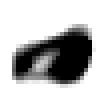

In [268]:
colorview(Gray,reshape(decoder(randn(20)),28,28))

In [235]:

using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra

In [269]:
function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (28*28, :))
    # test_x = parent(padarray(test_x, Fill(0, (2,2,0,0))))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

function save_to_images(x_batch, save_dir::String, prefix::String, num_images::Int64)
    print(size(x_batch))
    @assert num_images <= size(x_batch)[2]
    print(num_images)
    for i=1:num_images
        save(joinpath(save_dir, "$prefix-$i.png"), colorview(Gray, reshape(clamp.(x_batch[:,i], 0, 1), 28,28)' ) )
    end
    colorview(Gray, reshape(clamp.(x_batch[:,1], 0, 1), 28,28))
end

function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return x̂
end

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function visualise()
    # Define some parameters
    batch_size = 64
    shuffle = true
    num_images = 30
    epoch_to_load = 50
    # Load the model and test set loader
    encoder_μ, encoder_logvar, decoder = load_model("result", epoch_to_load)
    dataloader = get_test_loader(batch_size, shuffle)
    # Reconstruct and save some images
    for (x_batch, y_batch) in dataloader
        save_to_images(x_batch, "result", "test-image", num_images)
        x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
        save_to_images(x̂_batch, "result", "reconstruction", num_images)
        break
    end
end


visualise (generic function with 1 method)

In [270]:
visualise()

Loading model...Done
(784, 64)30(784, 64)30

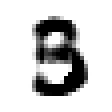

In [275]:
load("result/reconstruction-20.png")

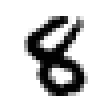

In [276]:

load("result/test-image-20.png")

In [ ]:
# Define some parameters
batch_size = 64
shuffle = true
num_images = 30
epoch_to_load = 10
# Load the model and test set loader
encoder_μ, encoder_logvar, decoder = load_model("result", epoch_to_load)
dataloader = get_test_loader(batch_size, shuffle)
# Reconstruct and save some images
for (x_batch, y_batch) in dataloader
    save_to_images(x_batch, "result", "test-image", num_images)
    x̂_batch = reconstruct_images(encoder_μ, encoder_logvar, decoder, x_batch)
    save_to_images(x̂_batch, "result", "reconstruction", num_images)
    break
end